In [1]:
 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split



print(os.listdir("C:\\Users\\Huda\\Downloads\\archive (1)"))


Using TensorFlow backend.


['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


In [2]:
base_skin_dir = os.path.join('', 'C:\\Users\\Huda\\Downloads\\archive (1)')


In [3]:
#Making Dictionary of images and labels
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying labels 

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [4]:
skin_df = pd.read_csv(os.path.join("",'C:\\Users\\Huda\\Downloads\\archive (1)\\HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

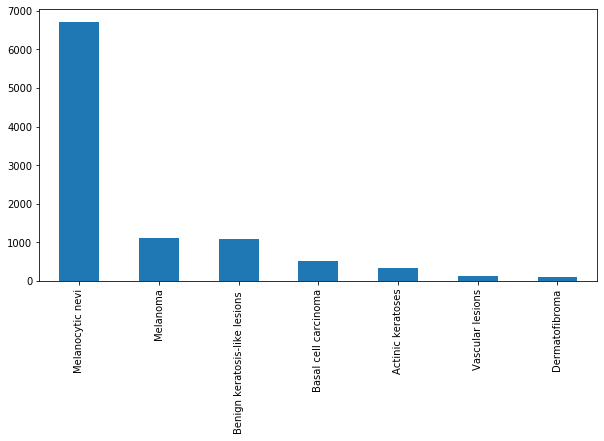

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

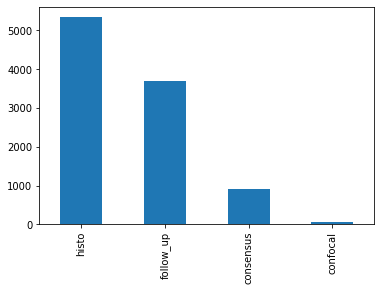

In [10]:
skin_df['dx_type'].value_counts().plot(kind='bar')

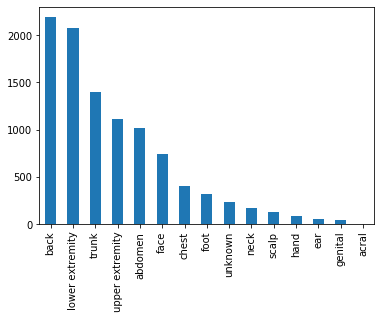

In [11]:
skin_df['localization'].value_counts().plot(kind='bar')

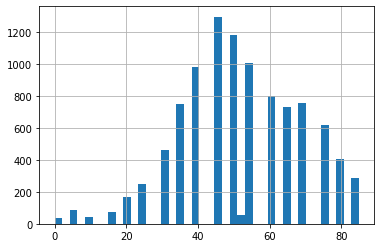

In [12]:
skin_df['age'].hist(bins=40)

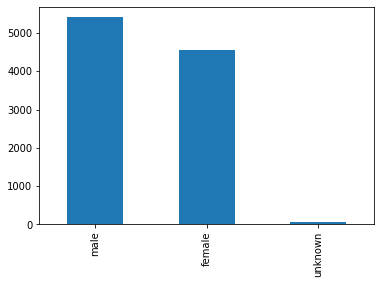

In [13]:
# the distribution of the sexes

skin_df['sex'].value_counts().plot(kind='bar')

In [14]:
#In this step images will be loaded into the column named image from the image path from the image folder.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((150,100))))


In [15]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2,"[[[190, 153, 196], [193, 156, 197], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2,"[[[25, 12, 21], [25, 14, 18], [25, 15, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2,"[[[187, 125, 136], [189, 133, 142], [194, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2,"[[[23, 12, 18], [24, 11, 20], [30, 14, 25], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Huda\Downloads\archive (1)\HAM10000_i...,Benign keratosis-like lesions,2,"[[[128, 89, 110], [141, 96, 119], [149, 104, 1..."


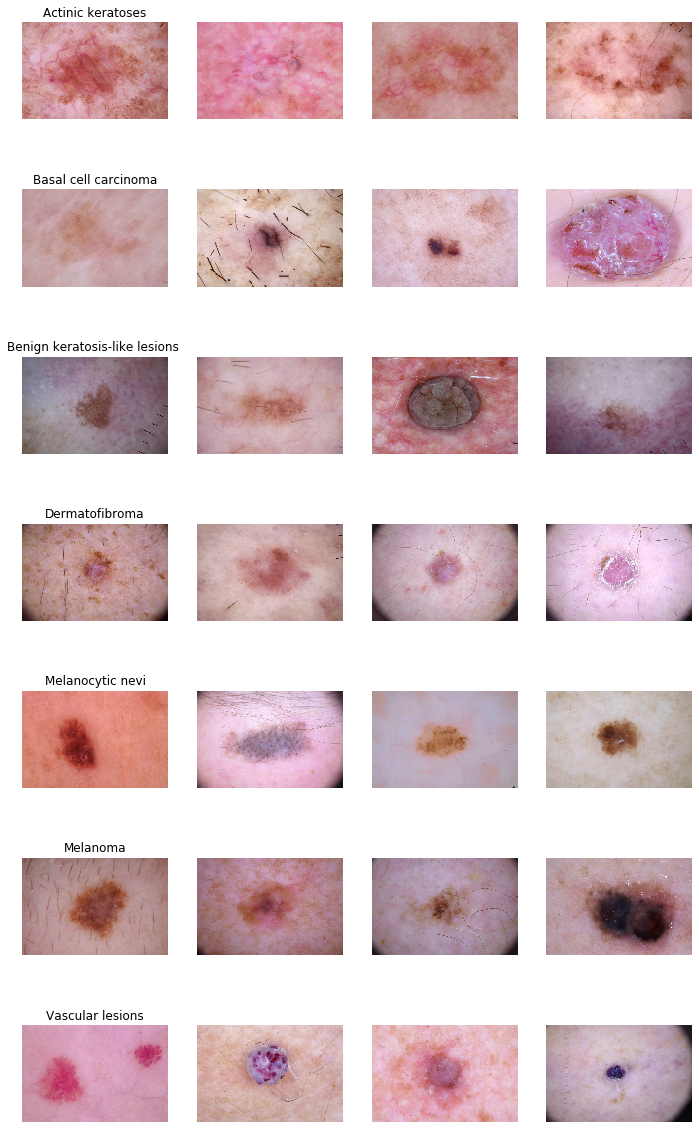

In [16]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (3*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=50)

In [17]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 150, 3)    10015
Name: image, dtype: int64

In [18]:
# See the image size distribution - should just return one row (all images are uniform)

# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 150, 3)    10015
Name: image, dtype: int64

In [19]:
#Organizing dataset - input and output
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [20]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

print(x_train_o)



        lesion_id      image_id   dx dx_type   age     sex     localization  \
8442  HAM_0006451  ISIC_0032274   nv   histo  50.0  female             back   
2908  HAM_0003941  ISIC_0029745  bcc   histo  35.0    male             face   
8909  HAM_0001989  ISIC_0030251   nv   histo  65.0    male  lower extremity   
58    HAM_0000700  ISIC_0028052  bkl   histo  60.0    male             face   
2960  HAM_0000868  ISIC_0032316  bcc   histo  65.0    male             face   
...           ...           ...  ...     ...   ...     ...              ...   
664   HAM_0006732  ISIC_0024336  bkl   histo  50.0  female  lower extremity   
7540  HAM_0003614  ISIC_0032560   nv   histo  40.0    male            chest   
7221  HAM_0001097  ISIC_0032950   nv   histo  50.0  female            chest   
1318  HAM_0006692  ISIC_0029630  mel   histo  80.0    male            scalp   
8915  HAM_0005086  ISIC_0030772   nv   histo  30.0    male             foot   

                                                   

In [21]:
# Normalization choose to divide it by 255 on the x values


In [22]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train=x_train.astype("float32")
x_test=x_test.astype("float32")


x_train /=225

x_test /=225

print(x_train.shape)
print(x_test)

(8012, 100, 150, 3)
[[[[0.96       0.52       0.6577778 ]
   [0.94666666 0.5288889  0.64444447]
   [0.9288889  0.51555556 0.60888886]
   ...
   [0.9066667  0.52       0.5911111 ]
   [0.9111111  0.51555556 0.61333334]
   [0.9288889  0.51111114 0.61777776]]

  [[0.94666666 0.52       0.64      ]
   [0.9111111  0.4888889  0.58666664]
   [0.92444444 0.52       0.59555554]
   ...
   [0.92       0.51111114 0.62222224]
   [0.9022222  0.50666666 0.59555554]
   [0.9066667  0.50222224 0.5822222 ]]

  [[0.92444444 0.50222224 0.6       ]
   [0.91555554 0.4888889  0.60888886]
   [0.91555554 0.46666667 0.6       ]
   ...
   [0.92       0.52       0.63555557]
   [0.9022222  0.50666666 0.58666664]
   [0.9066667  0.4977778  0.5644444 ]]

  ...

  [[0.83111113 0.46222222 0.50666666]
   [0.8622222  0.4977778  0.5511111 ]
   [0.84444445 0.48       0.53333336]
   ...
   [0.8755556  0.53333336 0.5688889 ]
   [0.8622222  0.5377778  0.5688889 ]
   [0.83555555 0.51111114 0.5422222 ]]

  [[0.84       0.48      

In [23]:
# Perform one-hot encoding on the labels

y_train = to_categorical(y_train_o, num_classes = 7) 

y_test = to_categorical(y_test_o, num_classes = 7)

In [24]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train.shape[0]

7210

In [25]:
# Reshape image in 3 dimensions (height = 100px, width = 150px , canal = 3 rgb)
x_train = x_train.reshape(x_train.shape[0], *(100, 150, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 150, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 150, 3))

In [26]:
# from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet

In [27]:
base_model = MobileNet(weights="imagenet", include_top=False , input_shape=(100, 150, 3))




C:\Users\Huda\AppData\Roaming\Python\Python37\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [28]:
from keras.models import Sequential , Model

In [29]:
from keras.layers import Dropout , GlobalAveragePooling2D
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 150, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 151, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 75, 32)        128 

In [31]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [32]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [36]:
# Fit the model

epochs = 50
batch_size = 10

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)


Epoch 1/50
721/721 [==============================] - 649s 900ms/step - loss: 1.0253 - accuracy: 0.6714 - val_loss: 0.7708 - val_accuracy: 0.7232
Epoch 2/50


C:\Users\Huda\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


721/721 [==============================] - 628s 871ms/step - loss: 0.7810 - accuracy: 0.7202 - val_loss: 0.7127 - val_accuracy: 0.7581
Epoch 3/50
721/721 [==============================] - 580s 805ms/step - loss: 0.7204 - accuracy: 0.7440 - val_loss: 0.6719 - val_accuracy: 0.7718
Epoch 4/50
721/721 [==============================] - 632s 876ms/step - loss: 0.6665 - accuracy: 0.7602 - val_loss: 0.6776 - val_accuracy: 0.7731
Epoch 5/50
721/721 [==============================] - 612s 849ms/step - loss: 0.6653 - accuracy: 0.7641 - val_loss: 0.7621 - val_accuracy: 0.7344
Epoch 6/50
721/721 [==============================] - 656s 910ms/step - loss: 0.6410 - accuracy: 0.7662 - val_loss: 1.1339 - val_accuracy: 0.6259
Epoch 7/50
721/721 [==============================] - 648s 899ms/step - loss: 0.6165 - accuracy: 0.7748 - val_loss: 0.6229 - val_accuracy: 0.7855
Epoch 8/50
721/721 [==============================] - 534s 741ms/step - loss: 0.6005 - accuracy: 0.7793 - val_loss: 0.5862 - val_accura

In [37]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    

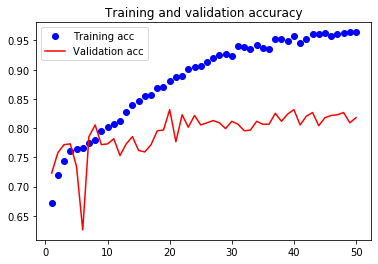

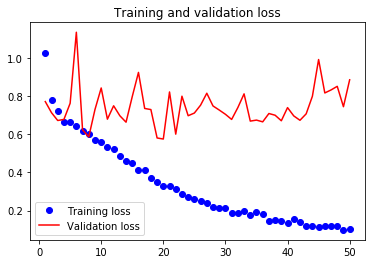

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [39]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 28s 35ms/step
Validation: accuracy = 0.817955  ;  loss_v = 0.884905
Test: accuracy = 0.814279  ;  loss = 0.802042


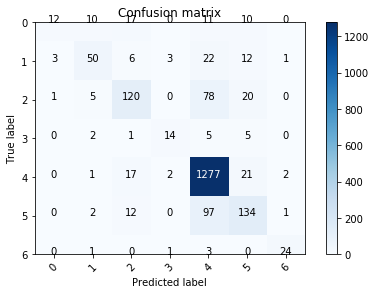

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

labels = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Malignant Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
print(classification_report(Y_true, Y_pred_classes, target_names=labels))

                      precision    recall  f1-score   support

   Actinic Keratoses       0.75      0.20      0.32        60
Basal Cell Carcinoma       0.70      0.52      0.60        97
    Benign Keratosis       0.69      0.54      0.60       224
      Dermatofibroma       0.70      0.52      0.60        27
  Malignant Melanoma       0.86      0.97      0.91      1320
    Melanocytic Nevi       0.66      0.54      0.60       246
    Vascular Lesions       0.86      0.83      0.84        29

            accuracy                           0.81      2003
           macro avg       0.75      0.59      0.64      2003
        weighted avg       0.80      0.81      0.80      2003



In [2]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

x_validate.shape

NameError: name 'X_train' is not defined